In [1]:
import os
import io
import random
import pandas as pd
import numpy as np
import pickle as pkl
from numpy import random
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import colorcet as cc
import seaborn as sns
import numba
import time
sns.set_style(style='white') 
sns.set(rc={'figure.figsize':(12,8)})
palette = sns.color_palette("bright", 15)
palette2 = sns.color_palette("dark", 10)
palette3 = sns.color_palette(cc.glasbey, n_colors=20)

from umap.umap_ import UMAP
from collections import Counter, defaultdict
import anndata as ad
import scib
print(ad.__version__)

import dask.dataframe as dd

from process import read_file_embeddings, plate_wise_spherize_and_normailize, average_wells

0.10.3


In [2]:
def read_file_embeddings(cpfname, fname, f_dim=512, feature_cols="micon_", is_moa=False):
    if cpfname.split('.')[-1] == 'parquet':
        df_check = pd.read_parquet(cpfname, low_memory=False)
    elif cpfname.split('.')[-1] == 'csv':
        df_check = pd.read_csv(cpfname, low_memory=False)
    df_check["Metadata_Fov"] = df_check["Metadata_Fov"].astype(int)
    if is_moa:
        df_check["Metadata_Moa"] = df_check["Metadata_InChIKey"].apply(lambda x: get_moa(x)).tolist()
    with open(fname, "rb") as f:
        emb, fname = pkl.load(f)

    f_name = []
    for x in fname:
        [f_name.extend([t.split("$")]) for t in x]

    df_emb = pd.DataFrame({"Metadata_Plate": [x[2] for x in f_name], "Metadata_Well": [x[3] for x in f_name], "Metadata_Fov": [int(x[4]) for x in f_name]})
    df_feat = pd.DataFrame(data=emb, columns=[f"{feature_cols}{i}" for i in range(f_dim)])
    df_emb = pd.concat([df_emb, df_feat], axis=1)
    df_check = df_check.merge(df_emb, on=["Metadata_Plate", "Metadata_Well", "Metadata_Fov"])
    return df_check

In [3]:
SMI2LABEL = {'c1ccc(-c2nn3c(c2-c2ccnc4cc(OCCN5CCOCC5)ccc24)CCC3)nc1': 1,
 'COc1ncc2cc(C(=O)Nc3cc(C(O)=NCc4cccc(Cl)c4)ccc3Cl)c(O)nc2n1': 2,
 'CC1CC2C3CC=C4CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO': 3,
 'C=CC1CN2CCC1CC2C(O)c1ccnc2ccc(OC)cc12': 4,
 'CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C': 5,
 'Cc1csc(-c2nnc(Nc3ccc(Oc4ncccc4-c4cc[nH]c(=N)n4)cc3)c3ccccc23)c1': 6,
 'O=C(c1ccccc1)N1CCC(CCCCN=C(O)C=Cc2cccnc2)CC1': 7,
 'CC(C)N=C(O)N1CCC(N=C2Nc3cc(F)ccc3N(CC(F)F)c3ccc(Cl)cc32)C1': 8,
 'CS(C)=O': 'control'}
SOURCE_LIST = ['source_2',  'source_3', 'source_5', 'source_6', 'source_7', 'source_8', 'source_11']

In [4]:
def generate_source_split(X, Y, Y_s, Y_b, source):
    X_train, Y_train, Y_s_train, Y_b_train = X[Y_s != source], Y[Y_s != source], Y_s[Y_s != source], Y_b[Y_s != source]
    X_test, Y_test, Y_s_test, Y_b_test = X[Y_s == source], Y[Y_s == source], Y_s[Y_s == source], Y_b[Y_s == source]
    
    return X_train, X_test, (Y_train, Y_s_train, Y_b_train), (Y_test, Y_s_test, Y_b_test)

def knn_classifier(df_train, df_test=None, n_neighbors=3, feature_col=["Emb_"], feature_col_test="Emb_", label_col="Metadata_Moa", label_col_test="Metadata_Moa", test_size=0.1):
    df_train.dropna(subset=label_col, inplace=True)
    X = df_train[feature_col]
    y = df_train[label_col].to_numpy().astype('str')
    if df_test is not None:
        df_test.dropna(subset=label_col_test, inplace=True)
        X_test = df_test[feature_col_test]
        y_test = df_test[label_col_test].to_numpy().astype('str')
        X_train = X
        y_train = y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    print(f"Training samples: {len(X_train)}. Testing samples: {len(X_test)}")
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors, metric = "cosine")
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test).reshape(-1, 1)
    v = [accuracy_score(y_test[y_test == i], y_pred[y_test == i]) for i in sorted(np.unique(y_test))]
    v += [accuracy_score(y_test, y_pred)]
    acc = pd.DataFrame({"Class": sorted(np.unique(y_test)) + ["Total"], "# of Samples": [len(y_test[y_test == i]) for i in sorted(np.unique(y_test))] + [len(y_test)], f"Acc_Neighbor={n_neighbors}": v}, index=None)
    return acc

In [5]:
def generate_visualization(df_check, feature_cols, hues= None, 
                           type_viz='tsne', perplexity=30, model_name="Default", n_color=12, legend=True, show_bg=False,
                          save_fig=False):
    if isinstance(feature_cols, str):
        cols = [c for c in df_check.columns if c.startswith(feature_cols)]
    else:
        cols = feature_cols
    X = df_check[cols].values
    total_number_of_hue = len(hues)
    if total_number_of_hue == 1:
        Y_total = [df_check[hues[0]].to_numpy()]
    else:
        Y_total = [df_check[hue].to_numpy() for hue in hues]
    
    if type_viz == 'tsne':
        tsne = TSNE(perplexity=perplexity)
        X_embedded = tsne.fit_transform(X)
    elif type_viz == 'umap':
        reducer = UMAP(n_neighbors=perplexity)
        X_embedded = reducer.fit_transform(X)
    else:
        raise Exception("{type_viz} not supported, choose from tsne/umap.")
        
    custom_palette = sns.color_palette(cc.glasbey, n_color)
    sns.set_style(style='white') 
    for hue_name, hue in zip(hues, Y_total):
        plt.figure()
        hue = [hue[i] if not pd.isnull(Y_total[0][i]) else np.nan for i in range(len(hue))]
        bg_index = [x for x in range(len(hue)) if hue[x] == 'bg']
        value_index = [x for x in range(len(hue)) if x not in bg_index]
        if legend:
            sns.scatterplot(x = X_embedded[value_index,0], y = X_embedded[value_index,1], hue=[hue[i] for i in value_index], palette=custom_palette, zorder=5)
            if bg_index and show_bg:
                sns.scatterplot(x = X_embedded[bg_index,0], y = X_embedded[bg_index,1], hue=[hue[i] for i in bg_index], color="lightgray", zorder=0)
        else:
            sns.scatterplot(x = X_embedded[value_index,0], y = X_embedded[value_index,1], hue=[hue[i] for i in value_index], palette=custom_palette, legend=None, zorder=5)
            if bg_index and show_bg:
                sns.scatterplot(x = X_embedded[bg_index,0], y = X_embedded[bg_index,1], hue=[hue[i] for i in bg_index], color="lightgray", legend=None, zorder=0)
        plt.xticks([])
        plt.yticks([])
        # plt.title(f"{model_name}_by_{hue_name}", loc='center')
        plt.legend(bbox_to_anchor=(1, 1), loc=2, ncol=2)
        if save_fig:
            plt.savefig(f"vis_{hue_name}.png", dpi=300)


In [6]:
def drop_bad_columns(df, cols=None):
    if not cols:
        cols = [c for c in df.columns if "Metadata_" not in c]
    stdev = [df[c].std() for c in cols]

    cols_to_drop = []
    cols_to_drop.extend([cols[i] for i, s in enumerate(stdev) if s < 0.1 or s > 5])
    cols_to_drop.extend([c for c in cols if "Nuclei_Correlation_RWC" in c])
    cols_to_drop.extend([c for c in cols if "Nuclei_Correlation_Manders" in c])
    cols_to_drop.extend([c for c in cols if "Nuclei_Granularity_14" in c])
    cols_to_drop.extend([c for c in cols if "Nuclei_Granularity_15" in c])
    cols_to_drop.extend([c for c in cols if "Nuclei_Granularity_16" in c])

    df = df[[c for c in df.columns if c not in cols_to_drop]]
    return df, cols_to_drop

In [7]:
def generate_visualization_two(df_check_1, df_check_2, feature_cols_1, feature_cols_2, hues=None, type_viz='tsne', \
                               perplexity=30, model_1_name="Default", model_2_name="Default_2", n_color=12, plot='all'):
    if isinstance(feature_cols_1, str):
        cols_1 = [c for c in df_check_1.columns if c.startswith(feature_cols_1)]
        cols_2 = [c for c in df_check_2.columns if c.startswith(feature_cols_2)]
    else:
        cols_1 = feature_cols_1
        cols_2 = feature_cols_2
    X_1 = df_check_1[cols_1].values
    X_2 = df_check_2[cols_2].values
    X_1_length = len(X_1)
    X = np.concatenate([X_1, X_2])
    total_number_of_hue = len(hues)
    if total_number_of_hue == 1:
        hue_1 = df_check_1[hues[0]]
        hue_2 = df_check_2[hues[0]]
        Y_1_total = [hue_1.to_numpy()]
        Y_2_total = [hue_2.to_numpy()]
        # Drop np.nan in hue order
        hue_1_order = [sorted(list(set(hue_1[~pd.isna(hue_1)].to_numpy().flatten())))]
        hue_2_order = [sorted(list(set(hue_2[~pd.isna(hue_2)].to_numpy().flatten())))]
    else:
        Y_1_total = [df_check_1[hue] for hue in hues]
        Y_2_total = [df_check_2[hue] for hue in hues]        
        hue_1_orders = [sorted(list(set(labels[~pd.isna(labels)].flatten()))) for labels in Y_1_total]
        hue_2_orders = [sorted(list(set(labels[~pd.isna(labels)].flatten()))) for labels in Y_2_total]
        
    if type_viz == 'tsne':
        tsne = TSNE(perplexity=perplexity)
        X_embedded = tsne.fit_transform(X)
    elif type_viz == 'umap':
        reducer = UMAP(n_neighbors=perplexity)
        X_embedded = reducer.fit_transform(X)
    else:
        raise Exception("{type_viz} not supported, choose from tsne/umap.")
        
    X_1_embedded = X_embedded[:X_1_length]
    X_2_embedded = X_embedded[X_1_length:]
    
    custom_palette1 = sns.color_palette("bright", 15)
    custom_palette2 = sns.color_palette("dark", 15)
    sns.set_style(style='white') 
    for hue_name, label_1, label_2, hue_1, hue_2 in zip(hues, Y_1_total, Y_2_total, hue_1_order, hue_2_order):
        plt.figure()
        if plot == 'all':
            sns.scatterplot(x = X_1_embedded[:,0], y = X_1_embedded[:,1], hue=label_1, hue_order=hue_1, legend='full', palette=custom_palette1, markers = ['o'])
            sns.scatterplot(x = X_2_embedded[:,0], y = X_2_embedded[:,1], hue=label_2, hue_order=hue_2, style=label_2, legend='full', palette=custom_palette2, markers = ['^']*len(hue_2))
            plt.title(f"{model_1_name}_vs_{model_2_name}_by_{hue_name}", loc='center')
            plt.legend(bbox_to_anchor=(1, 1), loc=2, ncol=4)
        elif plot == 'one':
            sns.scatterplot(x = X_1_embedded[:,0], y = X_1_embedded[:,1], hue=label_1, hue_order=hue_1, legend='full', palette=custom_palette1, markers = ['o'])
            plt.title(f"{model_1_name}_by_{hue_name}", loc='center')
            plt.legend(bbox_to_anchor=(1, 1), loc=2, ncol=4)
        elif plot == 'two':
            sns.scatterplot(x = X_2_embedded[:,0], y = X_2_embedded[:,1], hue=label_2, hue_order=hue_2, legend='full', palette=custom_palette2, markers = ['o'])
            plt.title(f"{model_2_name}_by_{hue_name}", loc='center')
            plt.legend(bbox_to_anchor=(1, 1), loc=2, ncol=4)

In [8]:
def NS_metric(df, feature_col, on="Metadata_Plate", topk=10, is_generated=False, all_negative=True):
    np_features = df[feature_col].to_numpy()
    knn = NearestNeighbors(n_neighbors=len(df), metric = "cosine")
    knn.fit(np_features)
    neighbours_mat = knn.kneighbors(np_features, return_distance=False)
    CONTROL = 'CS(C)=O'
    smiles = df["Metadata_SMILES"].to_numpy()
    res = []
    if on == "Metadata_Plate":
        plates = df["Metadata_Plate"].to_numpy()
        for i, (s, p, rank) in tqdm(enumerate(zip(smiles, plates, neighbours_mat))):
            if is_generated and i >= len(df)/2:
                break
            if all_negative:
                not_same_index = np.argwhere((plates!=p) | ((plates==p) & (smiles!=s)))
            else:
                not_same_index = np.argwhere(plates!=p)
            true_rank = [r for r in rank if r in not_same_index]
            if is_generated:
                true_rank = [r for r in true_rank if r >= len(df)/2]
            true_label = [smiles[r] == s for r in true_rank[:topk]]
            res.append(true_label)
    elif on == "Metadata_Source":
        sources = df["Metadata_Source"].to_numpy()
        for i, (s, p, rank) in tqdm(enumerate(zip(smiles, sources, neighbours_mat))):
            if is_generated and i >= len(df)/2:
                break
            if all_negative:
                not_same_index = np.argwhere((sources!=p) | ((sources==p) & (smiles!=s)))
            else:
                not_same_index = np.argwhere(sources!=p)
            true_rank = [r for r in rank if r in not_same_index]
            if is_generated:
                true_rank = [r for r in true_rank if r >= len(df)/2]
            true_label = [smiles[r] == s for r in true_rank[:topk]]
            res.append(true_label)
    ranking = np.array(res)
    control_index = [i for i in range(len(ranking)) if smiles[i] == CONTROL]
    treated_index = [i for i in range(len(ranking)) if smiles[i] != CONTROL]
    control_ranking = np.take(ranking, control_index, axis=0)
    treated_ranking = np.take(ranking, treated_index, axis=0)
    treated_smiles = np.take(smiles, treated_index, axis=0)
    print(ranking)
    def calc_acc(ranking, topk):
        acc_stats = []
        correct_smiles = []
        for i in range(1, topk+1):
            acc = 0
            cnt = 0
            correct_smiles.append(defaultdict(lambda: 0))
            for j in range(len(ranking)):
                if True in ranking[j,:i]:
                    acc += 1
                    correct_smiles[i-1][treated_smiles[j]] += 1
            acc_stats.append(acc/len(ranking))
        return (acc_stats, correct_smiles)
    
    return calc_acc(ranking, topk), calc_acc(treated_ranking, topk)

In [65]:
def NS_metric_across(subject, candidate, feature_col, on="Metadata_Plate", topk=10, all_negative=False, return_smiles=False):
    subject_features = subject[feature_col].to_numpy()
    candidate_features = candidate[feature_col].to_numpy()
    labels = candidate["Metadata_SMILES"].to_list()
    total_feature = np.concatenate([subject_features, candidate_features], axis=0)
    candidate_index_to_class = dict(zip(range(len(candidate_features)), labels))
    nneighbor = NearestNeighbors(n_neighbors=len(candidate_features), metric = "cosine")
    nneighbor.fit(candidate_features)
    subject_mat = nneighbor.kneighbors(subject_features, return_distance=False)
    subject_smiles = subject["Metadata_SMILES"]
    CONTROL = 'CS(C)=O'
    prediction = []
    if on == "Metadata_Plate":
        plates = subject["Metadata_Plate"].to_numpy()
        for i, (s, p, rank) in tqdm(enumerate(zip(subject_smiles, plates, subject_mat))):
            exclude_index = np.argwhere(plates!=p)
            if all_negative:
                exclude_index = np.argwhere((plates!=p) | ((plates==p) & (subject_smiles!=s)))
            true_rank = [candidate_index_to_class[r] for r in rank if r in exclude_index]
            TF_labels = [smi == s for smi in true_rank[:topk]]
            prediction.append(TF_labels)
    elif on == "Metadata_Batch":
        batches = subject["Metadata_Batch"].to_numpy()
        for i, (s, p, rank) in tqdm(enumerate(zip(subject_smiles, batches, subject_mat))):
            exclude_index = np.argwhere(batches!=p)
            if all_negative:
                exclude_index = np.argwhere((batches!=p) | ((batches==p) & (subject_smiles!=s)))
            true_rank = [candidate_index_to_class[r] for r in rank if r in exclude_index]
            TF_labels = [smi == s for smi in true_rank[:topk]]
            prediction.append(TF_labels)
    elif on == "Metadata_Source":
        sources = subject["Metadata_Source"].to_numpy()
        for i, (s, p, rank) in tqdm(enumerate(zip(subject_smiles, sources, subject_mat))):
            exclude_index = np.argwhere(sources!=p)
            if all_negative:
                exclude_index = np.argwhere((sources!=p) | ((sources==p) & (subject_smiles!=s)))
            true_rank = [candidate_index_to_class[r] for r in rank if r in exclude_index]
            TF_labels = [smi == s for smi in true_rank[:topk]]
            prediction.append(TF_labels)
    prediction = np.array(prediction)
    subject_smi = subject["Metadata_SMILES"].to_numpy()
    control_index = [i for i in range(len(subject_smi)) if subject_smi[i] == CONTROL]
    treated_index = [i for i in range(len(subject_smi)) if subject_smi[i] != CONTROL]
    control_ranking = np.take(prediction, control_index, axis=0)
    treated_ranking = np.take(prediction, treated_index, axis=0)
    treated_smiles = np.take(subject_smi, treated_index, axis=0)
    def calc_acc(ranking, topk, return_smiles=return_smiles):
        acc_stats = []
        correct_smiles = []
        for i in range(1, topk+1):
            acc = 0
            cnt = 0
            correct_smiles.append(defaultdict(lambda: 0))
            for j in range(len(ranking)):
                if True in ranking[j,:i]:
                    acc += 1
                    correct_smiles[i-1][treated_smiles[j]] += 1
            acc_stats.append(acc/len(ranking))
        if return_smiles:
            return (acc_stats, correct_smiles)
        else:
            return acc_stats
    
    return calc_acc(treated_ranking, topk)

In [10]:
def transform_pd_to_ad(df, feature_col):
    meta_cols = [c for c in df.columns if c.startswith("Metadata_")]
    features = df[feature_col].to_numpy()
    adata = ad.AnnData(features)
    adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]
    adata.var_names = feature_col
    for col in meta_cols:
        adata.obs[col] = pd.Categorical(df[col].to_numpy())
    return adata

In [ ]:
data = pd.read_csv("embeddings/target2.centered.csv", low_memory=False)

In [23]:
data.to_csv("embeddings/target2.centered.csv", index=False)

In [11]:
def knn_classifier(df_train, df_test=None, n_neighbors=3, feature_col=["Emb_"], feature_col_test="Emb_", label_col="Metadata_Moa", label_col_test="Metadata_Moa", test_size=0.1):
    df_train.dropna(subset=label_col, inplace=True)
    X = df_train[feature_col]
    y = df_train[label_col].to_numpy().astype('str')
    if df_test is not None:
        df_test.dropna(subset=label_col_test, inplace=True)
        X_test = df_test[feature_col_test]
        y_test = df_test[label_col_test].to_numpy().astype('str')
        X_train = X
        y_train = y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    print(f"Training samples: {len(X_train)}. Testing samples: {len(X_test)}")
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors, metric = "cosine")
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test).reshape(-1, 1)
    v = [accuracy_score(y_test[y_test == i], y_pred[y_test == i]) for i in sorted(np.unique(y_test))]
    v += [accuracy_score(y_test, y_pred)]
    acc = pd.DataFrame({"Class": sorted(np.unique(y_test)) + ["Total"], "# of Samples": [len(y_test[y_test == i]) for i in sorted(np.unique(y_test))] + [len(y_test)], f"Acc_Neighbor={n_neighbors}": v}, index=None)
    return acc

In [19]:
metadata_csv = pd.read_csv("datasets/treated_moa_target2/metadata_test")

In [12]:
cp_cols = [c for c in data.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]

In [67]:
cpfname = "embeddings/pos_control.centered.parquet"
fname = "embeddings/pos_control_raw_embeddings_supcon_freeze_img_train_14000.pkl"

pos_control = read_file_embeddings(cpfname, fname, f_dim=1000, feature_cols="micon_", is_moa=True)
cp_cols = [c for c in pos_control.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]
micon_cols = [c for c in pos_control.columns if c.startswith("micon_")]
pos_control = average_wells(pos_control, feature_cols="micon_")
# diff_smi = np.setdiff1d(OOD_treated_moa_raw_avg["Metadata_SMILES"].unique(), full_target2_embeddings["Metadata_SMILES"].unique())
# OOD_treated_moa_raw_avg_diff = OOD_treated_moa_raw_avg.loc[OOD_treated_moa_raw_avg["Metadata_SMILES"].isin(diff_smi)]


35136


35136it [06:23, 91.57it/s] 


In [15]:
cpfname = "embeddings/target2.centered.csv"
fname = "check_embeddings/treated_moa_target2/new_micon_divide255_unfreeze_img_resnet101_no_generate_no_aux_40000_original.pkl"

target2_unfreeze = read_file_embeddings(cpfname, fname, f_dim=1000, feature_cols="micon_", is_moa=False)
cp_cols = [c for c in target2_unfreeze.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]
micon_cols_proj = [c for c in target2_unfreeze.columns if c.startswith("micon_")]
target2_unfreeze_avg = average_wells(target2_unfreeze, feature_cols="micon_")

62162


62162it [1:19:09, 13.09it/s]


In [16]:
cpfname = "embeddings/target2.centered.csv"
fname = "check_embeddings/treated_moa_target2/new_micon_divide255_freeze_img_resnet101_no_generate_no_aux_40000_original.pkl"

target2_freeze = read_file_embeddings(cpfname, fname, f_dim=1000, feature_cols="micon_", is_moa=False)
cp_cols = [c for c in target2_freeze.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]
micon_cols_proj = [c for c in target2_freeze.columns if c.startswith("micon_")]
target2_freeze_avg = average_wells(target2_freeze, feature_cols="micon_")

62162


62162it [1:12:38, 14.26it/s]


In [60]:
cpfname = "embeddings/target2.centered.csv"
fname = "check_embeddings/treated_moa_target2/new_micon_divide255_freeze_img_resnet101_with_generate_with_aux_18000_original.pkl"

target2_freeze_with_all = read_file_embeddings(cpfname, fname, f_dim=1000, feature_cols="micon_", is_moa=False)
target2_freeze_with_all_avg = average_wells(target2_freeze_with_all, feature_cols="micon_")

62162


62162it [1:11:42, 14.45it/s]


In [15]:
cpfname = "embeddings/target2.centered.csv"
fname = "datasets/check_embeddings/treated_moa_target2_supervised_freeze_img_resnet101_with_aux_60000.pkl"

target2_freeze = read_file_embeddings(cpfname, fname, f_dim=1000, feature_cols="micon_", is_moa=False)
cp_cols = [c for c in target2_freeze.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]
micon_cols = [c for c in target2_freeze.columns if c.startswith("micon_")]
target2 = average_wells(target2_freeze, feature_cols="micon_")

62162


62162it [1:24:52, 12.21it/s]


In [23]:
knn_classifier(target2_freeze_avg.loc[target2_freeze_avg["Metadata_SMILES"] != "CS(C)=O"], n_neighbors=1, feature_col=cp_cols, feature_col_test=cp_cols, label_col="Metadata_SMILES", label_col_test="Metadata_SMILES", test_size=0.1)

/tmp/ipykernel_33182/585194778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.dropna(subset=label_col, inplace=True)


Training samples: 46563. Testing samples: 5174


,Class,# of Samples,Acc_Neighbor=1
0,C(#Cc1nc2ncccc2nc1OCCN1CCCC1)c1ccccc1,20,0.300000
1,C=C(C)C1C2OC(=O)C1C1(O)CC3OC34C(=O)OC2C14C,23,0.000000
2,C=C(N=C(O)C(=C)N=C(O)c1csc(C2=NC3c4csc(n4)C4N=...,25,0.360000
3,C=C1CCC2(O)C3Cc4ccc(O)c5c4C2(CCN3CC2CC2)C1O5,13,0.000000
4,C=CC(O)=Nc1cccc(N=c2[nH]c(Nc3ccc(OCCOC)cc3)ncc...,16,0.687500
...,...,...,...
297,c1cc(OCCN2CCCCC2)cc(-c2n[nH]c3ccc(-c4nc[nH]n4)...,19,0.157895
298,c1ccc(-c2ccc(CNc3nc(-c4ccccn4)nnc3-c3ccccc3)cc...,15,0.666667
299,c1ccc(-c2nn3c(c2-c2ccnc4cc(OCCN5CCOCC5)ccc24)C...,13,0.230769
300,c1ccc(C(OC2CCCN(CCc3ccc4c(c3)OCO4)C2)c2ccccc2)cc1,21,0.000000


In [26]:
treated_target2_unfreeze_avg = target2_unfreeze_avg.loc[target2_unfreeze_avg["Metadata_SMILES"] != "CS(C)=O"]

In [50]:
treated_target2_freeze_avg = target2_freeze_avg.loc[target2_freeze_avg["Metadata_SMILES"] != "CS(C)=O"]

In [61]:
treated_target2_freeze_with_all_avg = target2_freeze_with_all_avg.loc[target2_freeze_with_all_avg["Metadata_SMILES"] != "CS(C)=O"]

In [34]:
test = treated_target2_unfreeze_avg.sample(2000)

In [ ]:
target2_freeze_avg_processed = plate_wise_spherize_and_normailize(target2_freeze_avg, plate_col="Metadata_Plate", feature_cols=cp_cols, control_only=True)
treated_moa_raw_avg_processed = plate_wise_spherize_and_normailize(target2_freeze_avg_processed, plate_col="Metadata_Plate", feature_cols=micon_cols, control_only=True)

In [100]:
plate = np.random.choice(treated_target2_freeze_avg.loc[treated_target2_freeze_avg["Metadata_Source"] == 'source_2']["Metadata_Plate"].unique(),5,replace=False)


In [101]:
plate

array(['1053600674', '1086292389', '1086293911', '1086293133',
       '1086292884'], dtype=object)

In [95]:
test_ablated = treated_target2_freeze_avg.loc[treated_target2_freeze_avg["Metadata_Plate"].isin(plate)]
test_unfreeze = treated_target2_unfreeze_avg.loc[treated_target2_unfreeze_avg["Metadata_Plate"].isin(plate)]
test_with_all = treated_target2_freeze_with_all_avg.loc[treated_target2_freeze_with_all_avg["Metadata_Plate"].isin(plate)]

In [102]:
NS_metric_across(test_ablated, test_ablated, micon_cols_proj, on="Metadata_Plate", topk=10, all_negative=True)

0it [00:00, ?it/s]

[0.00203125,
 0.00484375,
 0.0084375,
 0.0115625,
 0.0134375,
 0.01625,
 0.019375,
 0.021875,
 0.025625,
 0.0290625]

In [103]:
NS_metric_across(test_unfreeze, test_unfreeze, micon_cols_proj, on="Metadata_Plate", topk=10, all_negative=True)

0it [00:00, ?it/s]

[0.001875,
 0.003125,
 0.005,
 0.0065625,
 0.00921875,
 0.01109375,
 0.01328125,
 0.01609375,
 0.0190625,
 0.0209375]

In [104]:
NS_metric_across(test_with_all, test_with_all, micon_cols_proj, on="Metadata_Plate", topk=10, all_negative=True)

0it [00:00, ?it/s]

[0.00265625,
 0.00578125,
 0.01,
 0.01421875,
 0.016875,
 0.020625,
 0.0234375,
 0.025625,
 0.02828125,
 0.030625]

In [105]:
NS_metric_across(test_ablated, test_ablated, cp_cols, on="Metadata_Plate", topk=10, all_negative=True)

0it [00:00, ?it/s]

[0.0,
 0.0,
 0.0,
 0.0003125,
 0.000625,
 0.000625,
 0.000625,
 0.0009375,
 0.0009375,
 0.00125]

In [111]:
cpfname = "embeddings/target2.centered.csv"
fname = "datasets/check_embeddings/treated_moa_target2_supervised_freeze_img_resnet101_with_aux_60000.pkl"

target2_sup = read_file_embeddings(cpfname, fname, f_dim=1000, feature_cols="micon_", is_moa=False)
cp_cols = [c for c in target2_sup.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]
micon_cols_sup = [c for c in target2_sup.columns if c.startswith("micon_")]
target2_sup = average_wells(target2_sup, feature_cols="micon_")

/data/yemin/MICON-main/process.py:147: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_check = pd.read_csv(cpfname)


50956


50956it [50:18, 16.88it/s]


In [30]:
cp_cols = [c for c in data.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]
# micon_cols_sup = [c for c in target2_sup.columns if c.startswith("micon_")]

In [70]:
from random import sample
single_source_plate = sample(list(select_df.loc[select_df["Metadata_Source"] == "source_4"]["Metadata_Plate"].unique()), 10)

In [77]:
metadata_csv.loc[metadata_csv["Metadata_Plate"].isin(single_source_plate)].to_csv("datasets/treated_moa_target2/metadata_test_10plate_in_source4.csv", index=False)

In [87]:
sources = ['source_2', 'source_3', 'source_5', 'source_4', 'source_7']
multi_source_plate = []
for s in sources:
    multi_source_plate.extend(sample(list(select_df.loc[select_df["Metadata_Source"] == s]["Metadata_Plate"].unique()), 2))

In [80]:
Counter(metadata_csv.loc[metadata_csv["Metadata_Plate"].isin(multi_source_plate)]['Metadata_Plate'])

Counter({'GR00004409': 6144,
         'GR00003300': 6144,
         'BR00121425': 3456,
         'ACPJUM182': 3456,
         'CP5-SC1-25': 3456,
         'JCPQC024': 3456,
         'JCPQC031': 3456,
         'BR00126114': 3456,
         'ACPJUM161': 3456,
         'CP3-SC2-25M': 3456})

In [116]:
micon_acc_3, micon_treated_acc_3 = NS_metric(target2_sup.loc[target2_sup["Metadata_Plate"].isin(multi_source_plate)], micon_cols_sup, on="Metadata_Source", all_negative=True)

0it [00:00, ?it/s]

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [108]:
target2_sup.drop(columns=micon_cols_sup).to_csv("embeddings/target2.centered.csv", index=False)

In [88]:
smi_to_id = defaultdict(set)
test_df = target2_sup.loc[target2_sup["Metadata_Source"] == "source_3"]
for smi, well in zip(test_df["Metadata_SMILES"],test_df["Metadata_Well"]):
    smi_to_id[smi].add(well)

In [21]:
from collections import Counter

smi = Counter(full_target2_embeddings["Metadata_Plate"])

In [211]:
cp_cols = [c for c in full_target2_embeddings.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]
micon_cols = [c for c in full_target2_embeddings.columns if c.startswith("micon_")]

In [77]:
cpfname = "embeddings/multi-source_treated_moa_target2_test.centered.parquet"
fname = "datasets/multi-source_treated_moa_target2_new_raw_embeddings_supcon_freeze_img_resnet101_with_aux_40000.pkl"

treated_moa_raw = read_file_embeddings(cpfname, fname, f_dim=1000, feature_cols="micon_", is_moa=True)
treated_moa_raw_avg = average_wells(treated_moa_raw, feature_cols="micon_")

cp_cols = [c for c in treated_moa_raw_avg.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]
micon_cols = [c for c in treated_moa_raw_avg.columns if c.startswith("micon_")]

# CP features
# treated_moa_raw_avg_processed = plate_wise_spherize_and_normailize(treated_moa_raw_avg, plate_col="Metadata_Source", feature_cols=cp_cols, control_only=True)
# MICON features
# treated_moa_raw_avg_processed_full = plate_wise_spherize_and_normailize(treated_moa_raw_avg_processed, plate_col="Metadata_Source", feature_cols=micon_cols, control_only=True)

4988


4988it [00:43, 114.19it/s]


302

In [33]:
treated_moa_raw_avg_processed_full = plate_wise_spherize_and_normailize(treated_moa_raw_avg_processed, plate_col="Metadata_Source", feature_cols=micon_cols, control_only=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.08s/it]


In [108]:
cpfname = "embeddings/single-source_treated_moa_target2_test.centered.parquet"
fname = "datasets/single-source_treated_moa_target2_new_raw_embeddings_supcon_freeze_img_resnet101_with_aux_40000.pkl"

treated_moa_raw = read_file_embeddings(cpfname, fname, f_dim=1000, feature_cols="micon_", is_moa=True)
treated_moa_raw_avg_2 = average_wells(treated_moa_raw, feature_cols="micon_")

cp_cols = [c for c in treated_moa_raw_avg.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]
micon_cols = [c for c in treated_moa_raw_avg.columns if c.startswith("micon_")]

# CP features
# treated_moa_raw_avg_processed = plate_wise_spherize_and_normailize(treated_moa_raw_avg, plate_col="Metadata_Source", feature_cols=cp_cols, control_only=True)
# MICON features
# treated_moa_raw_avg_processed_full = plate_wise_spherize_and_normailize(treated_moa_raw_avg_processed, plate_col="Metadata_Source", feature_cols=micon_cols, control_only=True)

3840


3840it [00:28, 136.87it/s]


In [128]:
micon_acc_1, micon_control_acc_1, micon_treated_acc_1 = NS_metric(treated_full_target2_embeddings[:1000], micon_cols, on="Metadata_Plate", all_negative=False)

0it [00:00, ?it/s]

In [403]:
# cp_cols = [c for c in OOD_treated_moa_raw_avg_diff.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]
micon_acc_2, micon_treated_acc_2 = NS_metric(OOD_treated_moa_raw_avg_diff, micon_cols, on="Metadata_Source", all_negative=False)

0it [00:00, ?it/s]

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [266]:
OOD_treated_moa_raw_avg_diff

cp_cols = [c for c in OOD_treated_moa_raw_avg_diff.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]

In [132]:
selected_smiles = [s[0] for s in sorted(Counter(micon_treated_acc_1[1]).items(), key=lambda x: x[1], reverse=True)][:10]

In [96]:
pos_smiles = [
       #'C=CC1CN2CCC1CC2C(O)c1ccnc2ccc(OC)cc12',
       'CC(C)N=C(O)N1CCC(N=C2Nc3cc(F)ccc3N(CC(F)F)c3ccc(Cl)cc32)C1',
       # 'CC1CC2C3CC=C4CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO',
       # 'CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C',
       'COc1ncc2cc(C(=O)Nc3cc(C(O)=NCc4cccc(Cl)c4)ccc3Cl)c(O)nc2n1',
       'Cc1csc(-c2nnc(Nc3ccc(Oc4ncccc4-c4cc[nH]c(=N)n4)cc3)c3ccccc23)c1',
       'O=C(c1ccccc1)N1CCC(CCCCN=C(O)C=Cc2cccnc2)CC1',
       'c1ccc(-c2nn3c(c2-c2ccnc4cc(OCCN5CCOCC5)ccc24)CCC3)nc1']

In [34]:
train_df, test_df = train_test_split(treated_moa_raw_avg_processed_full, test_size = 0.2)

In [80]:
from collections import Counter
a = Counter(cp_treated_acc[1])
b = Counter(micon_treated_acc_1[1])

In [81]:
selected_smiles_cp = [x[0] for x in sorted(a.items(), key=lambda x: x[1], reverse=True)[:10]]
selected_smiles_micon = [x[0] for x in sorted(b.items(), key=lambda x: x[1], reverse=True)[:10]]

In [88]:
selected_smiles = [x[0] for x in sorted(Counter(treated_full_v2_target2_embeddings["Metadata_SMILES"]).items(), key=lambda x: x[1], reverse=True)[:10]]

In [136]:
treated_full_target2_embeddings["Metadata_selected_SMILES"] = [x if x in selected_smiles else "bg" for x in treated_full_target2_embeddings["Metadata_SMILES"]]

In [94]:
treated_full_v2_target2_embeddings = treated_full_v2_target2_embeddings.loc[treated_full_v2_target2_embeddings["Metadata_SMILES"] != "CS(C)=O"]

In [112]:
test_df = full_target2_embeddings.sample(20000)
micon_acc_2, micon_treated_acc_2 = NS_metric(test_df, micon_cols, on="Metadata_Source", all_negative=False)
cp_acc_2, cp_treated_acc_2 = NS_metric(test_df, cp_cols, on="Metadata_Source", all_negative=False)

0it [00:00, ?it/s]

[[False False False ... False False False]
 [False False  True ... False  True  True]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [ True  True False ... False  True False]]


0it [00:00, ?it/s]

KeyboardInterrupt: 

In [271]:
test_df = pos_control.sample(5000)
micon_acc_3, micon_treated_acc_3 = NS_metric(test_df, cp_cols, on="Metadata_Source", all_negative=False)
# cp_acc_2, cp_treated_acc_2 = NS_metric(test_df, cp_cols, on="Metadata_Source", all_negative=False)

0it [00:00, ?it/s]

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ... False False  True]
 [False  True False ... False False False]
 [False False  True ... False  True  True]]


In [140]:
from collections import Counter
check_smi = [x[0] for x in Counter(micon_treated_acc_2[1][0]).most_common(10)]

In [213]:
check_smi_new = [x[0] for x in Counter(micon_treated_acc_3[1][0]).most_common(10)]

/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

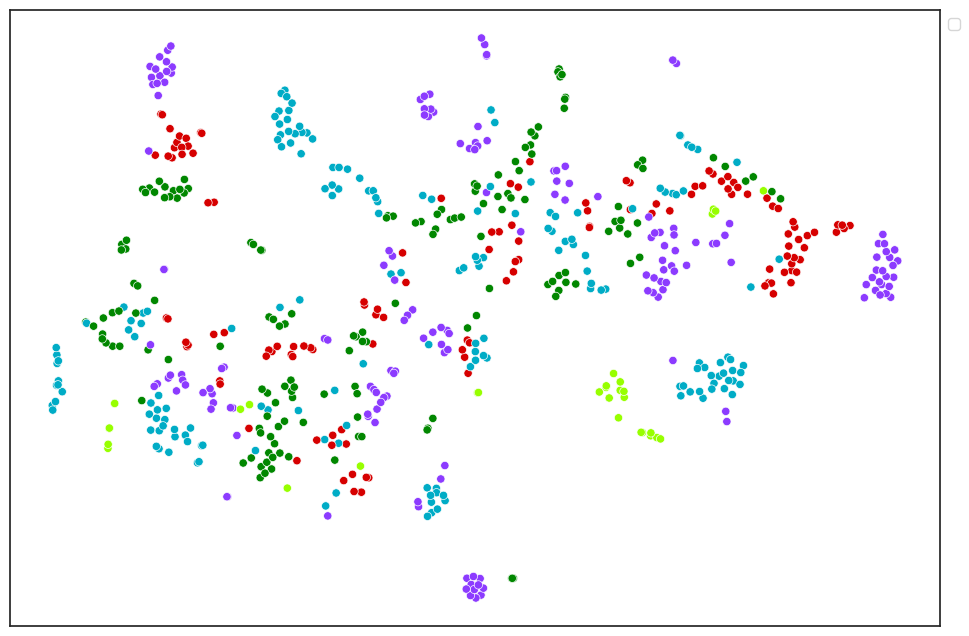

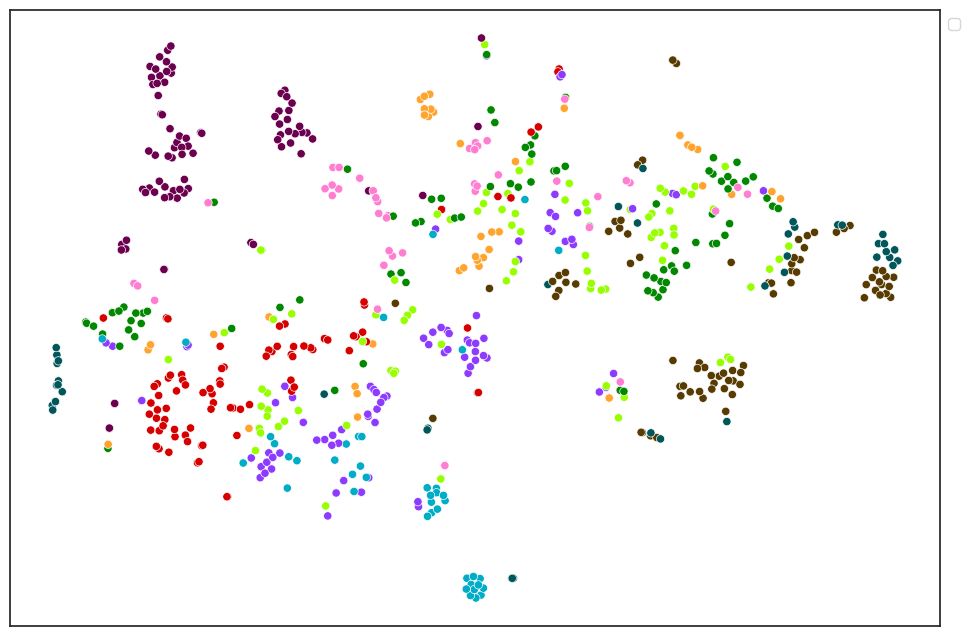

In [224]:
sns.set_style(style='white')
cp_cols = [c for c in treated_full_target2_embeddings.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]
micon_cols = [c for c in treated_full_target2_embeddings.columns if c.startswith("micon_")]
generate_visualization(treated_full_target2_embeddings.loc[(treated_full_target2_embeddings["Metadata_SMILES"].isin(check_smi)) & (treated_full_target2_embeddings["Metadata_Source"] != "source_9")], feature_cols=cp_cols, hues=['Metadata_Source', 'Metadata_SMILES'], type_viz='tsne', perplexity=20, model_name="Default", n_color=30,\
                      legend=False, save_fig=True)

/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

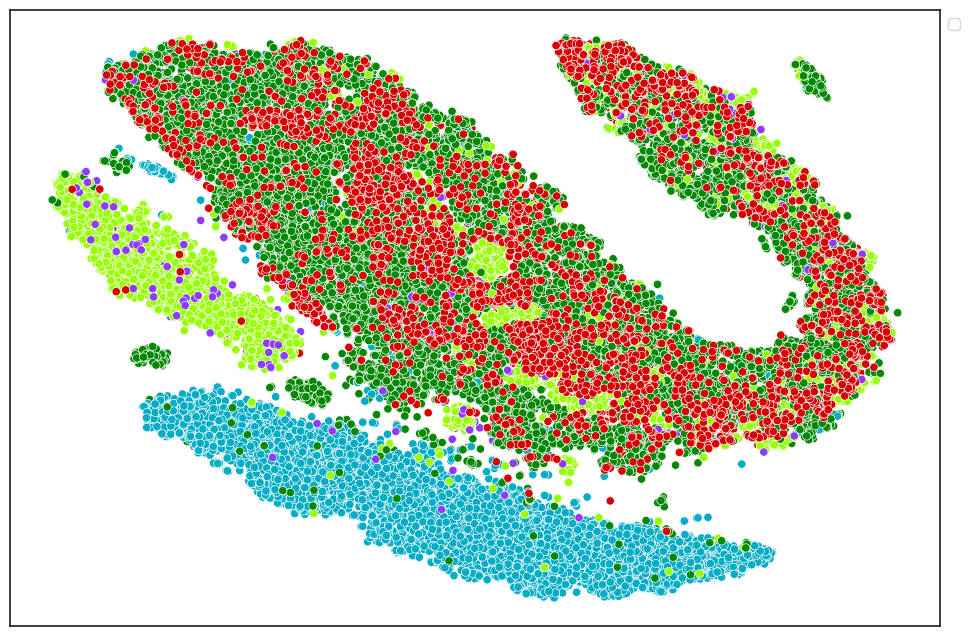

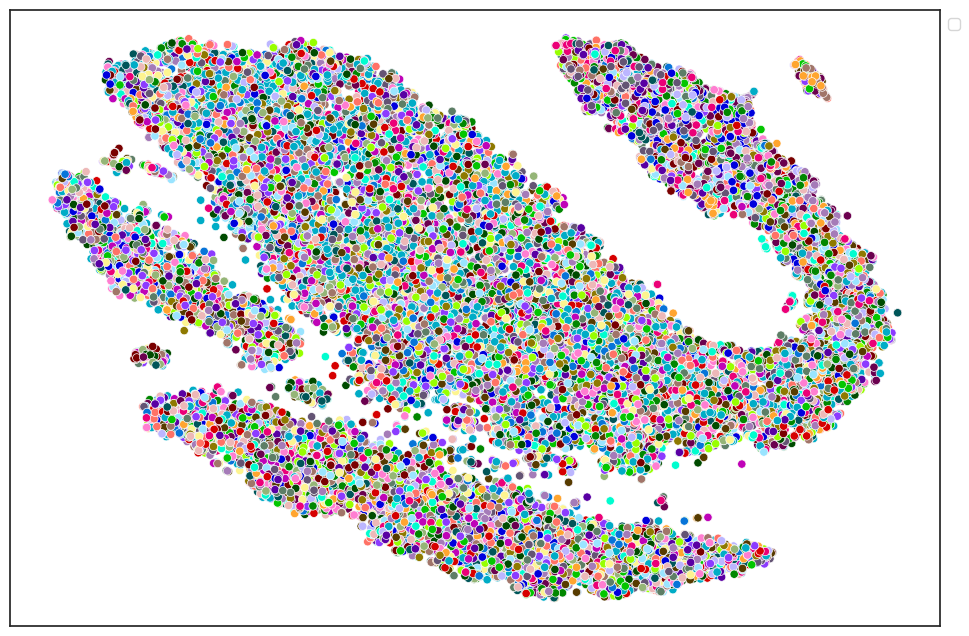

In [208]:
sns.set_style(style='white')
cp_cols = [c for c in treated_full_v2_target2_embeddings.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]
micon_cols = [c for c in new_full_target2_embeddings.columns if c.startswith("micon_")]
generate_visualization(new_full_target2_embeddings, feature_cols=micon_cols, hues=['Metadata_Source', 'Metadata_SMILES'], type_viz='tsne', perplexity=30, model_name="Default", n_color=30,\
                      legend=False, save_fig=False)

In [131]:
check_smi

['O=C(c1ccccc1)N1CCC(CCCCN=C(O)C=Cc2cccnc2)CC1',
 'COC(C(=O)n1cc2[nH][nH]c(=NC(O)c3ccc(N4CCN(C)CC4)cc3)c2c1)c1ccccc1',
 'CCC1C(=O)N(C)c2cnc(Nc3ccc(C(O)=NC4CCN(C)CC4)cc3OC)nc2N1C1CCCC1',
 'N=C(O)Nc1cc(-c2cccc(F)c2)sc1C(=O)NC1CCCNC1',
 'COCCN1CCN(Cc2ccc(-c3n[nH]c4c3C(=O)c3c(N=C(O)NN5CCOCC5)cccc3-4)cc2)CC1',
 'CC(=O)C(N=C(O)c1cccc(-c2ccccc2)n1)C(O)NC(CC(C)C)B(O)O',
 'Cc1cccc(-c2[nH]c(C(C)(C)C)nc2-c2ccc3c(c2)OCO3)n1',
 'N=c1nc(S)c2nc[nH]c2[nH]1',
 'CC1(C)C(=O)N=C2c3ccccc3C(=O)C(=O)C21',
 'CC(=Cc1csc(C)n1)C1CC2OC2(C)CCCC(C)C(O)C(C)C(=O)C(C)(C)C(O)CC(=O)O1']

/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

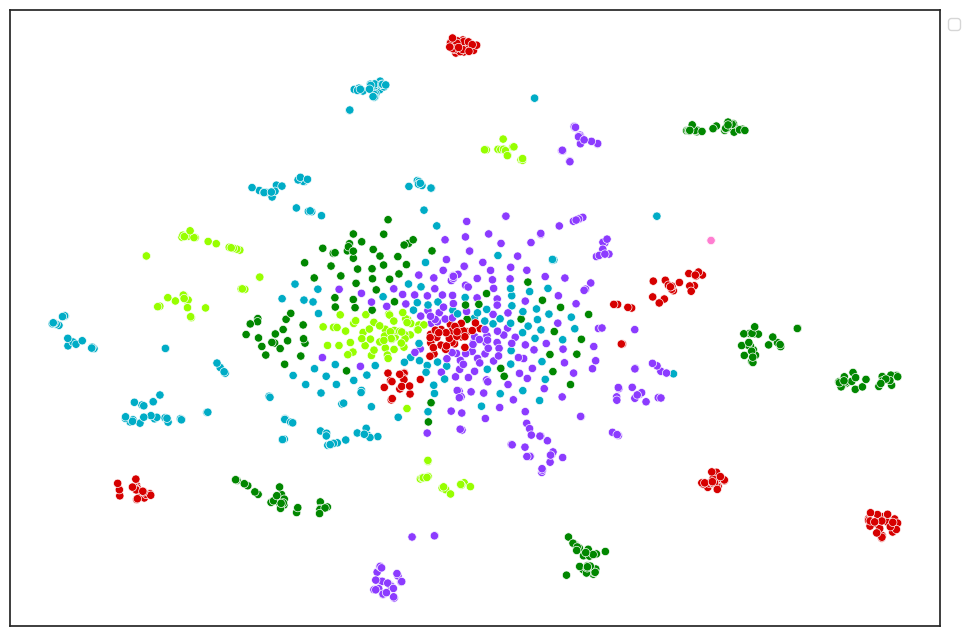

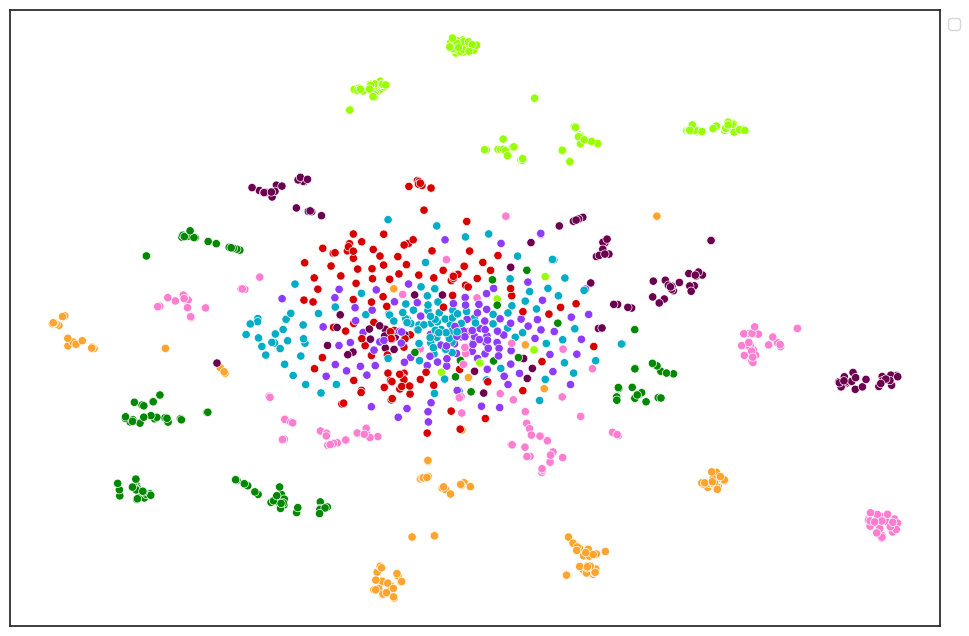

In [264]:
sns.set_style(style='white')
cp_cols = [c for c in pos_control_processed_2.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]
micon_cols = [c for c in pos_control_processed_2.columns if c.startswith("micon_")]
generate_visualization(pos_control_processed_2.loc[pos_control_processed_2["Metadata_SMILES"] != "CS(C)=O"].sample(1000), feature_cols=cp_cols, hues=['Metadata_Source', 'Metadata_SMILES'], type_viz='tsne', perplexity=50, model_name="Default", n_color=30,\
                      legend=False, save_fig=True)

In [92]:
### pos_control_avg_train["Metadata_SMILES"] = pos_control_avg_train["Metadata_SMILES"].apply(lambda x: SMI2LABEL[x])
# pos_control_avg["Metadata_SMILES"] = pos_control_avg["Metadata_SMILES"].apply(lambda x: SMI2LABEL[x])
generate_visualization_two(treated_moa_raw_avg_2.loc[treated_moa_raw_avg["Metadata_SMILES"].isin(selected_smiles)], treated_moa_raw_avg_processed.loc[treated_moa_raw_avg_processed["Metadata_SMILES"].isin(selected_smiles)], hues = ["Metadata_SMILES"], feature_cols_1=cp_cols, feature_cols_2=cp_cols,  type_viz='umap', perplexity=200)

NameError: name 'treated_moa_raw_avg_2' is not defined

In [191]:
res = pd.DataFrame()
# feature_cols = cp_cols
feature_cols = cp_cols
for i in range(5, 6):
    acc = knn_classifier(treated_moa_raw_avg_processed_full, \
                         n_neighbors=i, feature_col=feature_cols, feature_col_test=feature_cols, label_col="Metadata_Source", label_col_test="Metadata_Source", test_size=0.2)
    res = pd.concat([res, acc], axis=1)

Training samples: 3990. Testing samples: 998


In [192]:
res

,Class,# of Samples,Acc_Neighbor=5
0,source_11,150,0.860000
1,source_2,72,0.319444
2,source_3,73,0.397260
3,source_4,69,0.478261
4,source_5,150,0.773333
5,source_7,163,0.736196
6,source_9,321,0.825545
7,Total,998,0.716433


In [76]:
res2 = pd.DataFrame()
# feature_cols = cp_cols
feature_cols = cp_cols
for i in range(1,5):
    acc = knn_classifier(treated_moa_raw_avg_processed_full, \
                         n_neighbors=i, feature_col=feature_cols, feature_col_test=feature_cols, label_col="Metadata_Source", label_col_test="Metadata_Source", test_size=0.2)
    res2 = pd.concat([res2, acc], axis=1)

Training samples: 3990. Testing samples: 998
Training samples: 3990. Testing samples: 998
Training samples: 3990. Testing samples: 998
Training samples: 3990. Testing samples: 998


In [77]:
res2

,Class,# of Samples,Acc_Neighbor=1,Class,# of Samples,Acc_Neighbor=2,Class,# of Samples,Acc_Neighbor=3,Class,# of Samples,Acc_Neighbor=4
0,source_11,157,0.878981,source_11,157,0.929936,source_11,170,0.917647,source_11,131,0.923664
1,source_2,89,0.426966,source_2,77,0.454545,source_2,89,0.449438,source_2,82,0.439024
2,source_3,75,0.453333,source_3,69,0.550725,source_3,75,0.386667,source_3,84,0.404762
3,source_4,72,0.583333,source_4,87,0.632184,source_4,75,0.506667,source_4,67,0.492537
4,source_5,148,0.824324,source_5,150,0.766667,source_5,143,0.776224,source_5,153,0.764706
5,source_7,148,0.783784,source_7,158,0.658228,source_7,131,0.763359,source_7,146,0.760274
6,source_9,309,0.809061,source_9,300,0.666667,source_9,315,0.777778,source_9,335,0.805970
7,Total,998,0.741483,Total,998,0.694389,Total,998,0.720441,Total,998,0.723447


In [74]:
res3 = pd.DataFrame()
# feature_cols = cp_cols
feature_cols = cp_cols
for i in range(1,6):
    acc = knn_classifier(treated_moa_raw_avg, \
                         n_neighbors=i, feature_col=feature_cols, feature_col_test=feature_cols, label_col="Metadata_Source", label_col_test="Metadata_Source", test_size=0.2)
    res3= pd.concat([res3, acc], axis=1)
    

Training samples: 3990. Testing samples: 998
Training samples: 3990. Testing samples: 998
Training samples: 3990. Testing samples: 998
Training samples: 3990. Testing samples: 998
Training samples: 3990. Testing samples: 998


In [75]:
res3

,Class,# of Samples,Acc_Neighbor=1,Class,# of Samples,Acc_Neighbor=2,Class,# of Samples,Acc_Neighbor=3,Class,# of Samples,Acc_Neighbor=4,Class,# of Samples,Acc_Neighbor=5
0,source_11,158,1.0,source_11,155,1.0,source_11,175,1.000000,source_11,145,1.000000,source_11,158,0.993671
1,source_2,84,1.0,source_2,74,1.0,source_2,73,1.000000,source_2,73,1.000000,source_2,84,1.000000
2,source_3,84,1.0,source_3,74,1.0,source_3,82,1.000000,source_3,81,1.000000,source_3,75,1.000000
3,source_4,80,1.0,source_4,98,1.0,source_4,68,0.970588,source_4,79,0.987342,source_4,77,1.000000
4,source_5,151,1.0,source_5,147,1.0,source_5,148,1.000000,source_5,154,1.000000,source_5,161,1.000000
5,source_7,159,1.0,source_7,159,1.0,source_7,148,1.000000,source_7,139,1.000000,source_7,150,1.000000
6,source_9,282,1.0,source_9,291,1.0,source_9,304,0.996711,source_9,327,1.000000,source_9,293,0.996587
7,Total,998,1.0,Total,998,1.0,Total,998,0.996994,Total,998,0.998998,Total,998,0.997996


In [ ]:
treated_moa_raw_avg_processed

In [ ]:
res.loc[:, ~res.columns.duplicated()].to_csv("Target_2_KNN_retreival_test_acc_MICON.csv", index=False)

In [ ]:
res.loc[:, ~res.columns.duplicated()].to_csv("Target_2_KNN_retreival_test_acc_CP.csv", index=False)

In [202]:
def scatter_plot_with_error(x, y, dy, labels, shape):
    colors = plt.cm.Accent(np.linspace(0,1,len(y)))
    for i, (_y, _dy, _label, _shape) in enumerate(zip(y, dy, labels, shape)):
        plt.errorbar(x, _y, yerr=_dy, fmt=_shape, color=colors[i], elinewidth=1, capsize=3, label=_label)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1, 1), loc=2, ncol=1)

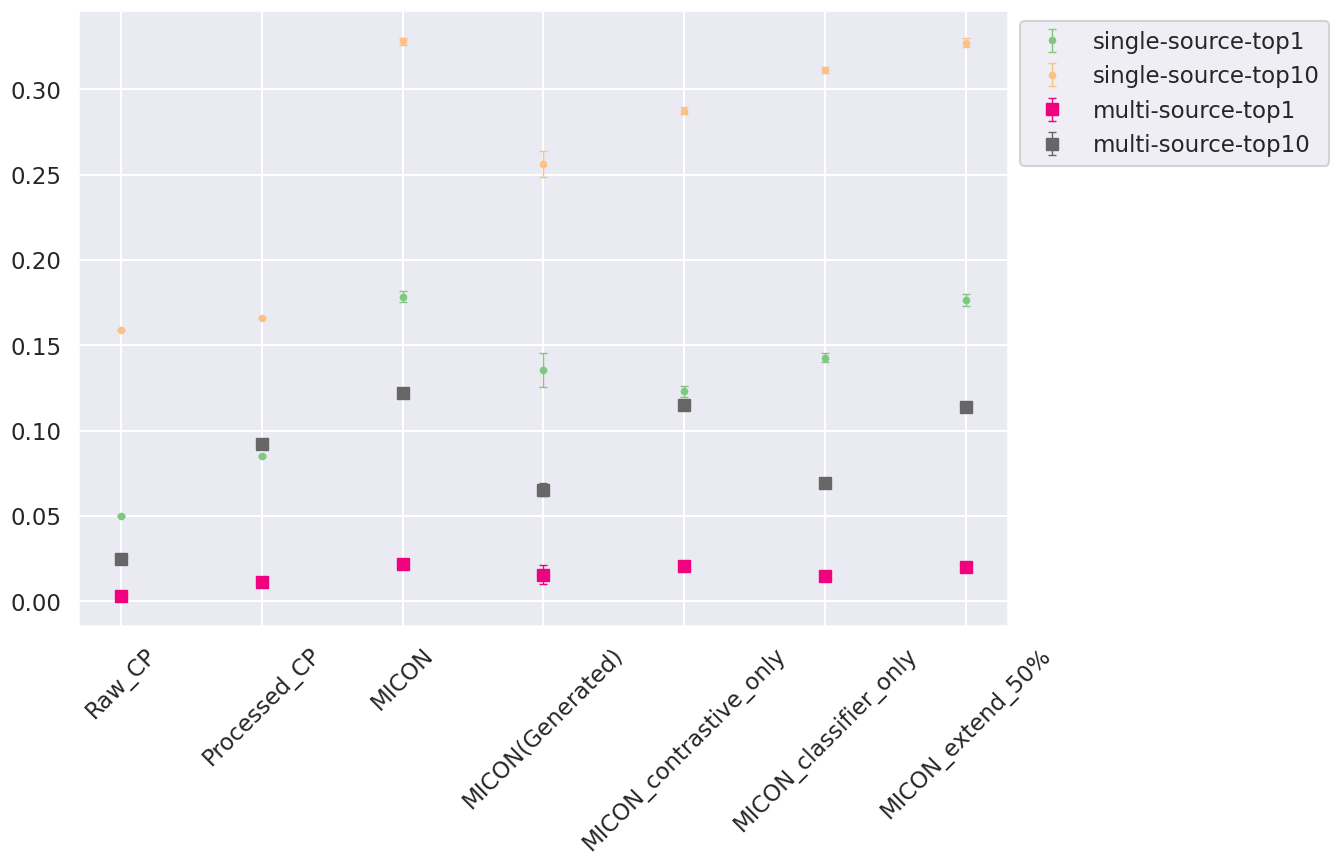

In [196]:
x = ['Raw_CP',
'Processed_CP',
'MICON',
'MICON(Generated)',
'MICON_contrastive_only',
'MICON_classifier_only',
'MICON_extend_50%'
]

labels = [
    'single-source-top1',
    'single-source-top10',
    'multi-source-top1',
    'multi-source-top10'
]

shape = [
    '.',
    '.',
    's',
    's',
]
y=[
    [0.0503, 0.0850, 0.1785, 0.1356, 0.123, 0.1427, 0.1765],
    [0.1591, 0.1661, 0.3282, 0.2564, 0.2876, 0.3114, 0.3275],
    [0.0031, 0.0116, 0.0217, 0.0157, 0.0207, 0.0151, 0.0199],
    [0.0246, 0.0922, 0.1221, 0.0655, 0.1150, 0.0695, 0.1139],

]

dy=[
    [0.0004, 0.0005, 0.0031, 0.0098, 0.0032, 0.0027, 0.0036],
    [0.0002, 0.0003, 0.0021, 0.0078, 0.0022, 0.0017, 0.0026],
    [0.001, 0.0007, 0.0021, 0.0058, 0.0032, 0.0027, 0.0016],
    [0.001, 0.0007, 0.0014, 0.0038, 0.0022, 0.0017, 0.0012],
]

scatter_plot_with_error(x,y,dy, labels, shape)


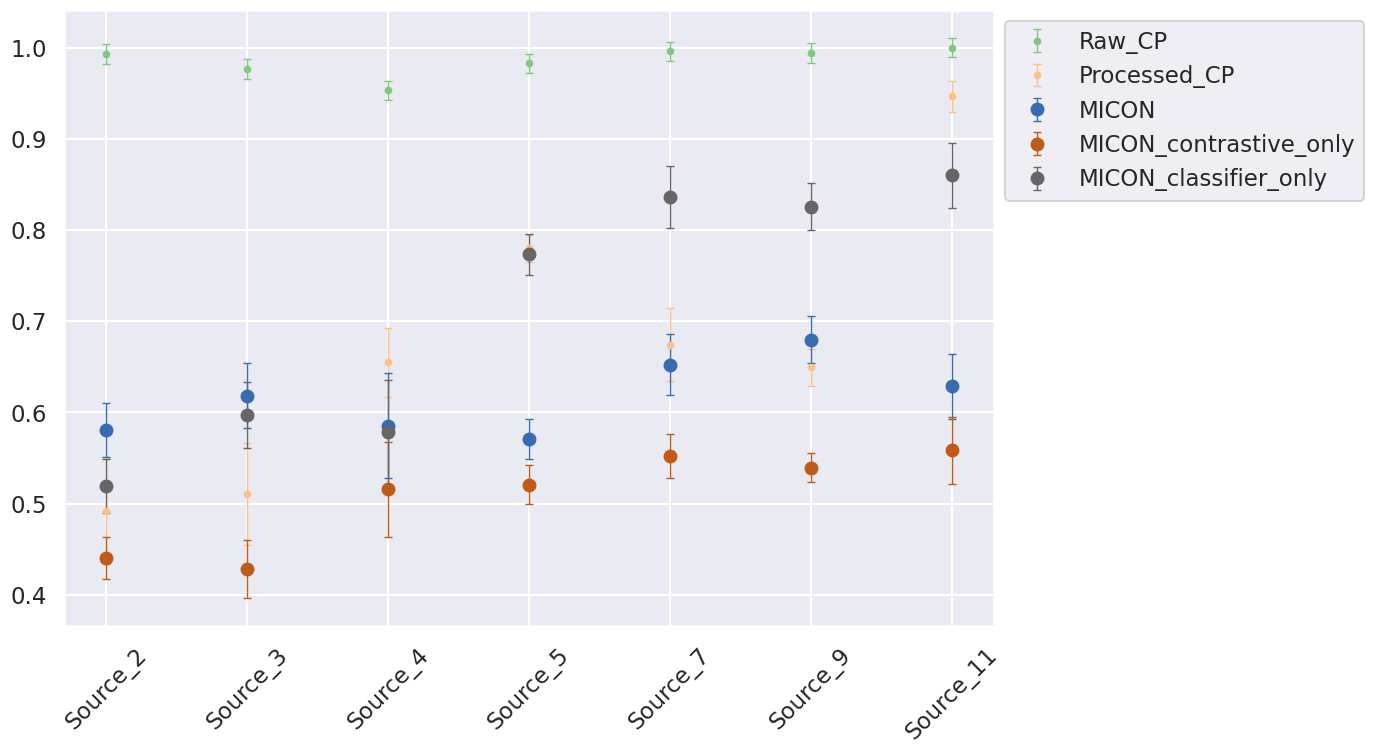

In [206]:
x = [
'Source_2',
'Source_3',
'Source_4',
'Source_5',
    'Source_7',
    'Source_9',
    'Source_11',
]

labels = [
'Raw_CP',
'Processed_CP',
'MICON',
'MICON_contrastive_only',
'MICON_classifier_only',
]

shape = [
    '.',
    '.',
    'o',
    'o',
    'o'
]
y=[
    [0.992941,0.976471,0.952941,0.982941,0.995941,0.993941,1],
    [0.4924194, 0.5105846, 0.6548228, 0.7799294, 0.674056, 0.6495266, 0.9466986],
    [0.5808502, 0.6184306, 0.5856132, 0.5709846, 0.6525296, 0.6796796, 0.6285886],
    [0.4408502, 0.4284306, 0.5156132, 0.5209846, 0.5525296, 0.5396796, 0.5585886],
    [0.519444, 0.597260, 0.578261, 0.773333, 0.836196, 0.825545, 0.860000],
]

dy=[
    [0.0105229359, 0.0105229359, 0.0105229359, 0.0105229359, 0.0105229359, 0.0105229359, 0.0105229359],
    [0.05865038778, 0.05561650695, 0.03764567634, 0.01445539284, 0.03994322956, 0.02056772835, 0.01714500227],
    [0.02992912556, 0.03575086826, 0.05768519437, 0.02229567416, 0.03385375761, 0.02558810906, 0.03568408778],
    [0.02292912556, 0.03175086826, 0.05168519437, 0.02129567416, 0.02385375761, 0.01558810906, 0.03668408778],
    [0.02992912556, 0.03575086826, 0.05768519437, 0.02229567416, 0.03385375761, 0.02558810906, 0.03568408778]
]

scatter_plot_with_error(x,y,dy, labels, shape)


In [ ]:
x = ['Raw_CP',
'Processed_CP',
'MICON (ID)',
'MICON(OOD)',
]

labels = [
    'single-source-top1',
    'single-source-top10',
    'multi-source-top1',
    'multi-source-top10'
]

shape = [
    '.',
    '.',
    's',
    's',
]
y=[
    [0.0503, 0.0850, 0.1785, 0.1356, 0.123, 0.1427, 0.1765],
    [0.1591, 0.1661, 0.3282, 0.2564, 0.2876, 0.3114, 0.3275],
    [0.0031, 0.0116, 0.0217, 0.0157, 0.0207, 0.0151, 0.0199],
    [0.0246, 0.0922, 0.1221, 0.0655, 0.1150, 0.0695, 0.1139],

]

dy=[
    [0.0004, 0.0005, 0.0031, 0.0098, 0.0032, 0.0027, 0.0036],
    [0.0002, 0.0003, 0.0021, 0.0078, 0.0022, 0.0017, 0.0026],
    [0.001, 0.0007, 0.0021, 0.0058, 0.0032, 0.0027, 0.0016],
    [0.001, 0.0007, 0.0014, 0.0038, 0.0022, 0.0017, 0.0012],
]

scatter_plot_with_error(x,y,dy, labels, shape)


In [408]:
cpfname = "embeddings/pos_control.centered.parquet"
fname = "embeddings/pos_control_embeddings_supcon_freeze_img_train_10000.pkl"

pos_ctl_raw = read_file_embeddings(cpfname, fname, f_dim=512, feature_cols="micon_", is_moa=False)
treated_moa_raw_avg = average_wells(pos_ctl_raw, feature_cols="micon_")

cp_cols = [c for c in treated_moa_raw_avg.columns if not c.startswith("Metadata_") and not c.startswith("micon_") and not c.endswith("_path")]
micon_cols = [c for c in treated_moa_raw_avg.columns if c.startswith("micon_")]

# CP features
# treated_moa_raw_avg_processed = plate_wise_spherize_and_normailize(treated_moa_raw_avg, plate_col="Metadata_Source", feature_cols=cp_cols, control_only=True)
# MICON features
# treated_moa_raw_avg_processed_full = plate_wise_spherize_and_normailize(treated_moa_raw_avg_processed, plate_col="Metadata_Source", feature_cols=micon_cols, control_only=True)

35136


35136it [06:16, 93.26it/s] 


/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

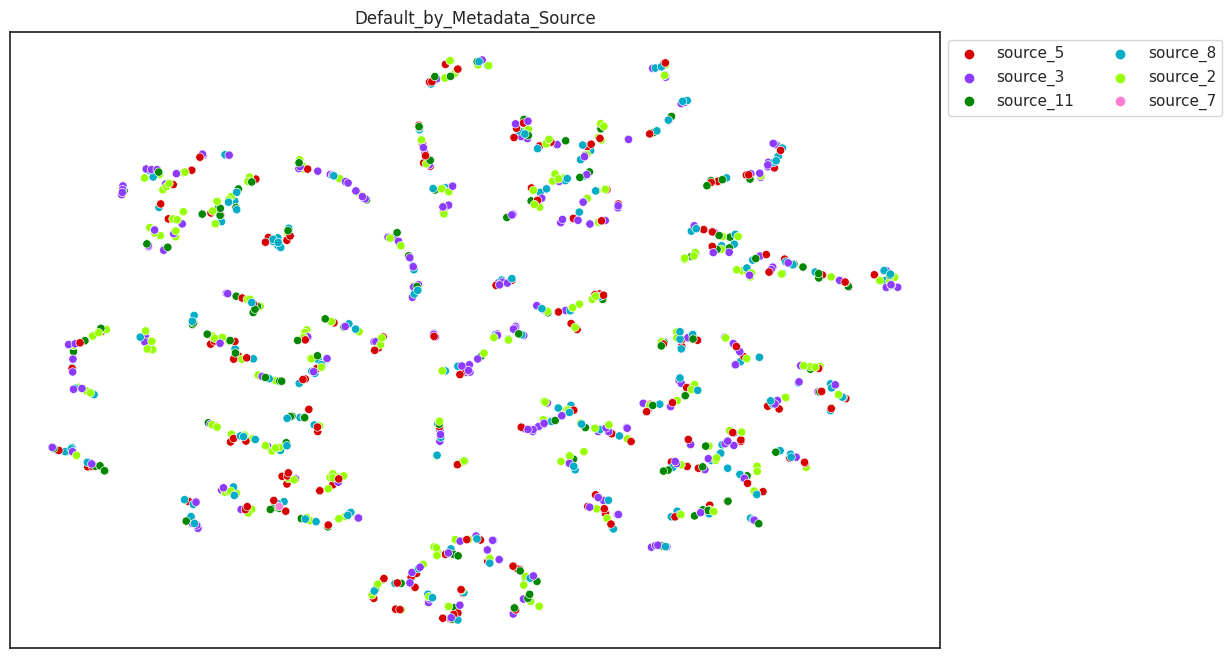

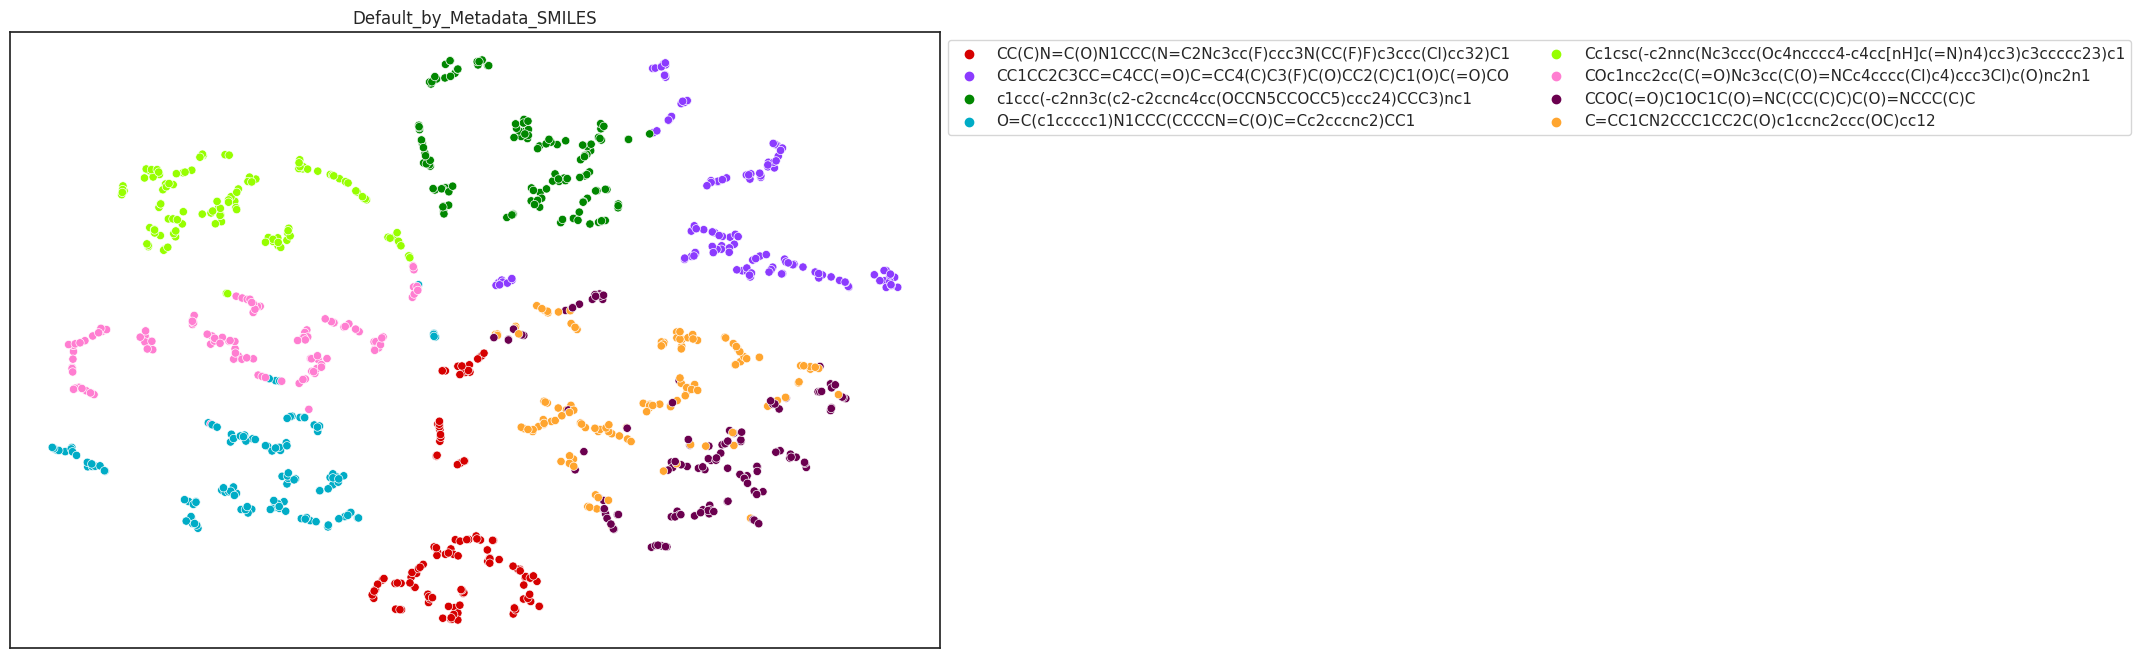

In [412]:
sns.set_style(style='white')
generate_visualization(treated_moa_raw_avg.loc[(treated_moa_raw_avg["Metadata_SMILES"] != "CS(C)=O")].sample(1000),\
                       feature_cols=micon_cols, hues=['Metadata_Source', 'Metadata_SMILES'], type_viz='tsne', perplexity=5, model_name="Default", n_color=30,\
                      legend=True)

In [406]:
test_set = treated_moa_raw_avg_processed_full.loc[treated_moa_raw_avg_processed_full["Metadata_SMILES"] != "CS(C)=O"].sample(2000)

In [377]:
micon_acc_2, micon_treated_acc_2 = NS_metric(test_set, micon_cols, on="Metadata_Source", all_negative=True)

0it [00:00, ?it/s]

[[False False False ... False False False]
 [False False False ... False False  True]
 [False False False ... False False False]
 ...
 [False False False ... False False  True]
 [False False False ... False False False]
 [False False False ... False False  True]]


In [378]:
micon_acc_2

([0.139, 0.236, 0.339, 0.414, 0.487, 0.541, 0.585, 0.624, 0.67, 0.701],
 [[], [], [], [], [], [], [], [], [], []])

In [367]:
treated_moa_raw_avg_processed = plate_wise_spherize_and_normailize(treated_moa_raw_avg, plate_col="Metadata_Batch", feature_cols=cp_cols, control_only=True)

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 68/72 [02:23<00:07,  1.80s/it]

No control samples found. Fall back to full normailization


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [02:30<00:00,  2.09s/it]


In [368]:
treated_moa_raw_avg_processed_full = plate_wise_spherize_and_normailize(treated_moa_raw_avg_processed, plate_col="Metadata_Batch", feature_cols=micon_cols, control_only=True)

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 68/72 [01:49<00:05,  1.49s/it]

No control samples found. Fall back to full normailization


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [01:54<00:00,  1.59s/it]
